In [1]:
import os
import csv
from pathlib import Path
import numpy as np
import pandas as pd
import skimage.filters as sfi
import skimage.measure as sme
import skimage.segmentation
from skimage.feature import canny, peak_local_max
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.feature import texture as sft
import skimage.morphology as smo
from PIL import Image, ImageEnhance
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt
import math
import cv2
import sys
import seaborn as sn

In [2]:
inputfolder = Path("Saps excuded\Included SAPS")
#For region exclusion and for future implementing of adaptability to different resolution images

def inc_contrast(self,contrast_times=15,dilation=False,dilation_selem_size=10):
#Increase conrast of input to clarify edges; contrast works better at lower values for dilation so repeated at line 41
    enhance = ImageEnhance.Contrast(self)
    cont = enhance.enhance(contrast_times)
    cont = np.array(cont)
#Dilation of image - This shrinks pollen silhouettes to help with clustering issues
    selem = smo.disk(dilation_selem_size)    
    dilated = smo.dilation(cont,selem)
    if dilation == True:
        return dilated
    else:
        return cont

In [3]:
#Denoising filter. Devened used for edge detection while evened used to accurately find highest and lowest grey values for watershed markers

def get_markers(self,evened_selem_size=4,markers_contrast_times=15,markers_sd=0.25):
    selem = smo.disk(evened_selem_size)
    evened = sfi.rank.mean_bilateral(inc_contrast(self,contrast_times=markers_contrast_times),selem)
#Markers defined by highest and lowest grey levels. Level reduced/decreased by 1/4 SD 
    high = np.amax(evened)
    low = np.amin(evened)
    std = np.std(evened) 
    neatarray = np.array(self)    
    markers = np.zeros_like(neatarray)
    markers[evened < low +(markers_sd*std)] = 3
    markers[evened > high-(markers_sd*std)] = 2
    return markers

In [4]:
def segment(self,sigma=1,canny_lt=100,canny_ht=1,
            contrast_times=10,dilated_evened_selem_size=2,evened_selem_size=10,dilation_selem_size=4,
            markers_meaned_selem_size=4,markers_contrast_times=15,markers_sd=0.25,return_mask=False):
    
    selem = smo.disk(evened_selem_size)        
    evened = sfi.rank.mean_bilateral(inc_contrast(self,contrast_times=contrast_times),selem)
    selem = smo.disk(dilated_evened_selem_size)
    devened = sfi.rank.mean_bilateral(inc_contrast(self,contrast_times=contrast_times,dilation=True,dilation_selem_size=dilation_selem_size),selem)   
#Canny edge detection filter detects object edges and outputs boolean array
    elevation_map = canny(devened,sigma=sigma,low_threshold=canny_lt,high_threshold=canny_ht) 

#Convert canny output binary array to use as mask
    elevation_map = elevation_map.astype(int)
    
#Watershed function floods regions from markers
    segmentation = skimage.segmentation.watershed(evened,get_markers(self,evened_selem_size=markers_meaned_selem_size,markers_contrast_times=markers_contrast_times,markers_sd=markers_sd),
                                                  mask=elevation_map, connectivity = 1)
    # thresh = sfi.threshold_otsu(segmentation)
#Fill smaller holes within regions - usually due to noise; Label each region
    segmentation = nd.binary_fill_holes(segmentation)
    # elevation_map2 = canny(segmentation, sigma = 1 ,low_threshold=70 ,high_threshold=1) 
    # segmentation = skimage.segmentation.watershed(elevation_map2, markers,mask=elevation_map, connectivity = 0.5)   
    label = sme.label(segmentation)
    if return_mask==True:
        return elevation_map
    else:
        return label
 


In [5]:
measuresdf = pd.DataFrame(columns=['Area','Perimeter','Major_axis_length','Minor_axis_length','Equivalent_diameter',
                                   'Eccentricity','Extent','Contrast','Dissimilarity', 'Homogeneity', 'ASM', 'Energy',
                                   'Correlation','P-no','Bounding_box','Local_centroid'])
countdf = pd.DataFrame(columns=['Count','Actual'])

def measure_props(self,sigma=1,canny_lt=100,canny_ht=1,
                  contrast_times=10,dilated_evened_selem_size=2,evened_selem_size=10,dilation_selem_size=4,
                  markers_meaned_selem_size=4,markers_contrast_times=15,markers_sd=0.25):
    img = Image.open(path).convert('L')
    w,h = img.size
    area = w*h
    no = []    
    tempdf = pd.DataFrame()
    for i,region in enumerate(sme.regionprops(segment(img, sigma=sigma,canny_lt=canny_lt,canny_ht=canny_ht,
                                                      contrast_times=contrast_times,dilated_evened_selem_size=dilated_evened_selem_size,
                                                      evened_selem_size=evened_selem_size,dilation_selem_size=dilation_selem_size,
                                                      markers_meaned_selem_size=markers_meaned_selem_size,markers_contrast_times=markers_contrast_times,markers_sd=markers_sd))):
#Attempt to filter out non-pollen regions using size and circularity factor
        if area > region.area > 250: #and (region.perimeter**2)/(4*math.pi*region.area) < 1.5:
            no.append(i)
            coins = imread(self, as_gray=True)
            coins = img_as_ubyte(coins)
#Get region bounding box and crop image to it so GLCM functions only apply to relevant region
            coord = region.bbox                
            boxx = coins[coord[0]:coord[1],coord[2]:coord[3]]
#Defines inputs for GLCM
            distances = np.array([1])
            angles = np.array([0, np.pi/8, np.pi/4, 3*(np.pi/8), np.pi/2, 5*(np.pi/8), 3*(np.pi/4), 7*(np.pi/8)])
#if function is because some bounding box coordinates were coming back incorrect
            if boxx.size>0:   
                glcm = sft.greycomatrix(boxx,distances,angles,levels=256)
                correlation = sft.greycoprops(glcm, prop='correlation').mean()
                contrast = sft.greycoprops(glcm, prop='contrast').mean()
                dissimilarity = sft.greycoprops(glcm, prop='dissimilarity').mean()
                homogeneity = sft.greycoprops(glcm, prop='homogeneity').mean()
                ASM = sft.greycoprops(glcm, prop='ASM').mean()
                energy = sft.greycoprops(glcm, prop='energy').mean()
                tempdf = tempdf.append(pd.Series([region.area, region.perimeter, region.major_axis_length, region.minor_axis_length,
                                    region.equivalent_diameter, region.eccentricity, region.extent, contrast, dissimilarity,
                                    homogeneity, ASM, energy, correlation,i,region.bbox, region.local_centroid],name=path.stem,
                                    index=['Area','Perimeter','Major_axis_length','Minor_axis_length','Equivalent_diameter',
                                    'Eccentricity','Extent','Contrast','Dissimilarity', 'Homogeneity', 'ASM', 'Energy',
                                    'Correlation','P-no','Bounding_box','Local_centroid']))
            else:
                continue
            
    return tempdf
                
    test = len(no)
    countdf.append(pd.Series([test], name=path.stem))

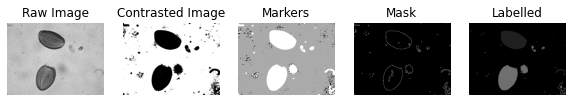

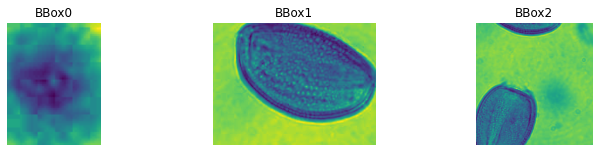

,ASM,Area,Bounding_box,Contrast,Correlation,Dissimilarity,Eccentricity,Energy,Equivalent_diameter,Extent,Homogeneity,Local_centroid,Major_axis_length,Minor_axis_length,P-no,Perimeter
Agapanthus praecox v%2320BCC6,0.001666,13754.0,"(54, 197, 167, 358)",94.859767,0.980912,5.973825,0.795733,0.040704,132.333430,0.756005,0.304134,"(55.83844699723717, 76.14890213755999)",170.466831,103.242825,6.0,460.232539
Agapanthus praecox v%2320BCC6,0.004604,500.0,"(145, 385, 184, 414)",52.930783,0.981240,3.680087,0.933571,0.067683,25.231325,0.442087,0.432619,"(19.498, 12.836)",50.174887,17.982277,19.0,129.053824
Agapanthus praecox v%2320BCC6,0.008316,1890.0,"(262, 318, 322, 365)",2.537187,0.977717,1.155074,0.591580,0.090995,49.055303,0.670213,0.545809,"(28.63121693121693, 23.033333333333335)",55.630419,44.851810,22.0,215.858910


KeyboardInterrupt: 

In [91]:
for i,path in enumerate(inputfolder.glob("*.jpg")):
    CANNY_SIGMA = 1
    CANNY_LOW_THRESHOLD = 100
    CANNY_HIGH_THRESHOLD = 2
    CONTRAST_INCREASE = 50
    DILATION_EVENED_CONTRASTING_DISK_SELEM_SIZE = 2
    DILATION_SELEM_SIZE = 4
    EVENED_DISK_SELEM_SIZE = 4
    MARKERS_MEANED_SELEM_SIZE = 4
    MARKERS_CONTRAST_TIMES = 100
    MARKERS_SD_TIMES = 0.25
    
    coins = imread(path, as_gray=True)
    
    output = measure_props(path,sigma=CANNY_SIGMA,canny_lt=CANNY_LOW_THRESHOLD,canny_ht=CANNY_HIGH_THRESHOLD,
                  contrast_times=CONTRAST_INCREASE,dilated_evened_selem_size=DILATION_EVENED_CONTRASTING_DISK_SELEM_SIZE,evened_selem_size=EVENED_DISK_SELEM_SIZE,
                  dilation_selem_size=DILATION_SELEM_SIZE,markers_meaned_selem_size=MARKERS_MEANED_SELEM_SIZE,markers_contrast_times=MARKERS_CONTRAST_TIMES,markers_sd=MARKERS_SD_TIMES)
    measuresdf = measuresdf.append(output)
        
    inp = Image.open(path).convert('L')
    plt.fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(10,15))#, sharex=True, sharey=True)
    ax1.imshow(inp, cmap="gray")
    ax1.axis('off')
    ax1.set_title('Raw Image')
    ax2.imshow(inc_contrast(inp,contrast_times=CONTRAST_INCREASE,dilation=False,dilation_selem_size=DILATION_SELEM_SIZE), cmap="gray")
    ax2.axis('off')
    ax2.set_title('Contrasted Image')
    ax3.imshow(get_markers(inp,evened_selem_size=EVENED_DISK_SELEM_SIZE,markers_contrast_times=MARKERS_CONTRAST_TIMES,markers_sd=MARKERS_SD_TIMES), cmap="gray")
    ax3.axis('off')
    ax3.set_title('Markers')
    ax4.imshow(segment(inp,sigma=CANNY_SIGMA,canny_lt=CANNY_LOW_THRESHOLD,canny_ht=CANNY_HIGH_THRESHOLD,
                  contrast_times=CONTRAST_INCREASE,dilated_evened_selem_size=DILATION_EVENED_CONTRASTING_DISK_SELEM_SIZE,evened_selem_size=EVENED_DISK_SELEM_SIZE,
                  dilation_selem_size=DILATION_SELEM_SIZE,markers_meaned_selem_size=MARKERS_MEANED_SELEM_SIZE,markers_contrast_times=MARKERS_CONTRAST_TIMES,markers_sd=MARKERS_SD_TIMES,return_mask=True), cmap="gray")
    ax4.axis('off')
    ax4.set_title('Mask')
    ax5.imshow(segment(inp,sigma=CANNY_SIGMA,canny_lt=CANNY_LOW_THRESHOLD,canny_ht=CANNY_HIGH_THRESHOLD,
                  contrast_times=CONTRAST_INCREASE,dilated_evened_selem_size=DILATION_EVENED_CONTRASTING_DISK_SELEM_SIZE,evened_selem_size=EVENED_DISK_SELEM_SIZE,
                  dilation_selem_size=DILATION_SELEM_SIZE,markers_meaned_selem_size=MARKERS_MEANED_SELEM_SIZE,markers_contrast_times=MARKERS_CONTRAST_TIMES,markers_sd=MARKERS_SD_TIMES), cmap="gray")
    ax5.axis('off')
    ax5.set_title('Labelled')
    plt.show(plt.fig)
    
    rows=1
    cols=2
    fig=plt.figure(figsize = (20,2),constrained_layout=True)
    gs = fig.add_gridspec(1,output['Bounding_box'].size)
    for i,a in enumerate(output['Bounding_box']):
        b = coins[output['Bounding_box'][i-1][0]:output['Bounding_box'][i-1][1],output['Bounding_box'][i-1][2]:output['Bounding_box'][i-1][3]]
        cols += 1
        fig.add_subplot(gs[0,i:],title="BBox"+f'{i}').axis('off')
        
        plt.imshow(b)
    plt.show()
    pd.set_option('display.max_columns', 500)
    display(output)